In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [15]:
# Загрузим файлы
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
train.describe()

,ЛПНП
count,553.000000
mean,0.596745
std,0.490995
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [17]:
train.head(5)

,ID,ЛПНП
0,k31__1__1,1
1,k31__5__5,0
2,k31__6__6,0
3,k31__17__17,0
4,k31__16__16,1


In [18]:
train['ЛПНП'].value_counts()

,count
ЛПНП,
1,330
0,223


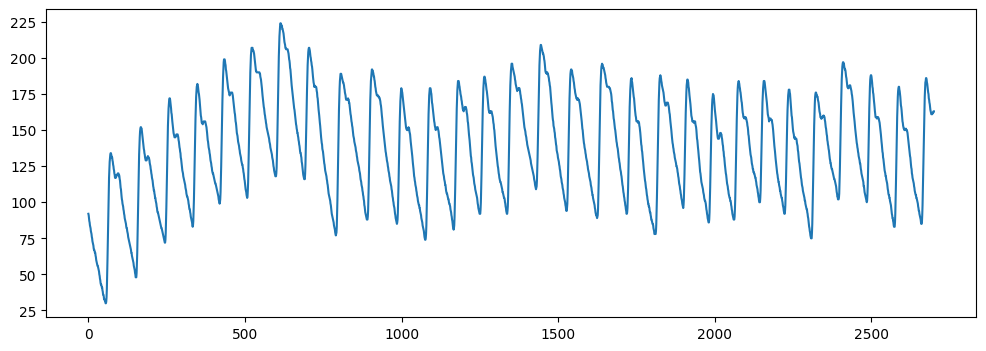

In [19]:
# Загрузим одну из фотоплетизмограмм
file_id = train.iloc[4]['ID']
path = 'ppgs/' + file_id + '.npy'
ppg = np.load(path)
plt.figure(figsize=(12,4))
plt.plot(ppg)

In [20]:
# Разделим обучающую выборку на обучающую и валидационную часть
train, val = train_test_split(train, test_size=0.2, stratify=train['ЛПНП'], random_state=42)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [138]:
#Создаем датасет
class PPGDataset(Dataset):
    def __init__(self, df, target_col='ЛПНП', training=True):
        """
        Параметры:
            df (DataFrame): Pandas DataFrame с метаданными
            target_col (str): Название колонки с целевой переменной ('ЛПНП')
            training (bool): Флаг - тренировочный режим или нет (влияет на возвращаемые значения)
        """
        self.data = df
        self.target_col = target_col
        self.training = training
        self.fs = 100

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Загрузка и обработка одного образца данных по индексу

        Возвращает:
            Для тренировочного режима: (ppg_signal, target)
            Для тестового режима: (ppg_signal, file_id)
        """
        row = self.data.iloc[idx]
        file_id = row['ID']

        path = f'ppgs/{file_id}.npy'
        ppg = np.load(path)

        b, a = signal.butter(3, [0.8 / self.fs, 5 / self.fs], 'bandpass')
        ppg = signal.filtfilt(b, a, ppg)

        ppg = ppg[:128*20]

        ppg = torch.tensor(ppg.copy(), dtype=torch.float32).view(1, -1)

        if self.training:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return {'ppg': ppg, 'target': target}
        return {'ppg': ppg, 'file_id': file_id}

In [139]:
# Используемая нейронная сеть (аналог LeNet)
class PPG_CNN_1D(nn.Module):
    def __init__(self, number_of_classes):
        super(PPG_CNN_1D, self).__init__()

        K = 9
        P = (K-1)//2

        self.features = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size = K, padding = P),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size = 9),

            nn.Conv1d(64, 64, kernel_size = 4),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size = 9),

            nn.Conv1d(64, 64, kernel_size = 4),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, number_of_classes)
        )

        self.classifier = nn.Linear(64, number_of_classes)


    def _initialize_weights(self, method):
        init_funcs = {
            'xavier': nn.init.xavier_normal_,
            'he': lambda w: nn.init.kaiming_normal_(w, nonlinearity='tanh'),
            'default': lambda w: None
        }
        init_func = init_funcs.get(method, init_funcs['default'])
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                if method != 'default':
                    init_func(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


    def forward(self, x):

        x = F.dropout(x,p=0.5, training=self.training)

        x = self.features(x).squeeze(2)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [140]:
#Вспомогательная функция оценки
def evaluate(model, loss_function, val_loader, device):
    model.eval()
    val_loss = 0.0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for data in val_loader:
            inputs = data['ppg']
            if 'target' in data:
                target = data['target']
            else:
                target = None

            inputs = inputs.to(device)
            if target is not None:
                target = target.to(device).float()

            outputs = model(inputs)

            if target is not None:
                target_flat = target.view(-1)
                outputs_flat = outputs.view(-1)

                loss = loss_function(outputs_flat, target_flat)
                val_loss += loss.item() * target.size(0)

                val_true.append(target_flat.cpu())
                val_pred.append(torch.sigmoid(outputs_flat.cpu()))

    if len(val_true) > 0:
        val_true = torch.cat(val_true)
        val_pred = torch.cat(val_pred)
    else:
        val_true = torch.tensor([])
        val_pred = torch.tensor([])

    return val_true, val_pred, (val_loss / len(val_loader.dataset) if len(val_loader) > 0 else 0)

In [141]:
#Функция для обучения модели
def train_ppg_model(model, train_loader, val_loader, loss_function,
                    optimizer, epochs, metric=None, device='cuda'):

    train_losses, val_losses, val_aucs = [], [], []

    model.to(device)

    best_auc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_metric_value = 0.0

        for data in train_loader:
            ppg = data['ppg'].to(device)
            target = data['target'].to(device).float()

            optimizer.zero_grad()
            outputs = model(ppg)

            loss_value = loss_function(outputs.squeeze(), target.squeeze())
            loss_value.backward()
            optimizer.step()

            train_loss_epoch += loss_value.item() * ppg.size(0)

        train_loss_epoch /= len(train_loader.dataset)

        val_true, val_pred, val_loss_epoch = evaluate(
            model, loss_function, val_loader, device
        )

        try:
            val_auc_score = roc_auc_score(val_true.numpy(), val_pred.numpy())
        except ValueError:
            val_auc_score = 0.5

        if val_auc_score > best_auc:
            best_auc = val_auc_score
            best_model_state = model.state_dict()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss_epoch:.4f}, Val Loss: {val_loss_epoch:.4f}, Val AUC: {val_auc_score:.4f}")

        train_losses.append(train_loss_epoch)
        val_losses.append(val_loss_epoch)
        val_aucs.append(val_auc_score)

    return train_losses, val_losses, val_aucs, best_model_state

In [142]:
#Объявление параметров и обучение
BATCH = 10
EPOCHS = 100
LR = 2 * 1e-4

train_dataset = PPGDataset(train, training=True)
val_dataset = PPGDataset(val, training=True)
test_dataset = PPGDataset(test, training=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

model = PPG_CNN_1D(number_of_classes=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
loss_function = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = roc_auc_score

history = train_ppg_model(model=model,
                                   train_loader=train_loader,
                                   val_loader=val_loader,
                                   optimizer=optimizer,
                                   loss_function=loss_function,
                                   epochs=EPOCHS,
                                   device=device,
                                   metric=metric)

best_model_state = history[-1]

Epoch 1/100, Train Loss: 0.6871, Val Loss: 0.6961, Val AUC: 0.6158
Epoch 2/100, Train Loss: 0.6865, Val Loss: 0.6724, Val AUC: 0.6141
Epoch 3/100, Train Loss: 0.6669, Val Loss: 0.6788, Val AUC: 0.6067
Epoch 4/100, Train Loss: 0.6746, Val Loss: 0.6685, Val AUC: 0.6125
Epoch 5/100, Train Loss: 0.6688, Val Loss: 0.6693, Val AUC: 0.6111
Epoch 6/100, Train Loss: 0.6709, Val Loss: 0.6690, Val AUC: 0.6094
Epoch 7/100, Train Loss: 0.6676, Val Loss: 0.6693, Val AUC: 0.6104
Epoch 8/100, Train Loss: 0.6656, Val Loss: 0.6602, Val AUC: 0.6098
Epoch 9/100, Train Loss: 0.6673, Val Loss: 0.6597, Val AUC: 0.6114
Epoch 10/100, Train Loss: 0.6596, Val Loss: 0.6638, Val AUC: 0.6128
Epoch 11/100, Train Loss: 0.6634, Val Loss: 0.6604, Val AUC: 0.6111
Epoch 12/100, Train Loss: 0.6624, Val Loss: 0.6711, Val AUC: 0.6118
Epoch 13/100, Train Loss: 0.6696, Val Loss: 0.6709, Val AUC: 0.6101
Epoch 14/100, Train Loss: 0.6645, Val Loss: 0.6628, Val AUC: 0.6114
Epoch 15/100, Train Loss: 0.6583, Val Loss: 0.6656, Val A

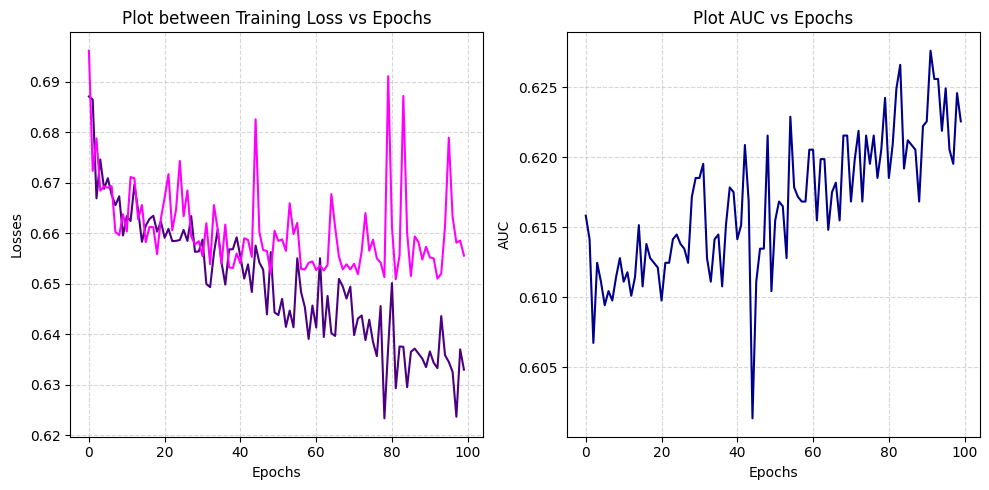

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history[0], color='indigo')
ax1.plot(history[1], color='magenta')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Losses')
ax1.set_title('Plot between Training Loss vs Epochs')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.plot(history[2], color='darkblue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('AUC')
ax2.set_title('Plot AUC vs Epochs')
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [144]:
for name, param in model.named_parameters():
    if param.grad is None:
        print(f"{name} has no grad")
    else:
        print(f"{name} grad norm: {param.grad.norm()}")

features.0.weight grad norm: 0.9241366982460022
features.0.bias grad norm: 9.787718413534208e-10
features.1.weight grad norm: 0.13646003603935242
features.1.bias grad norm: 0.0428115539252758
features.4.weight grad norm: 3.646385908126831
features.4.bias grad norm: 3.8090497866960504e-08
features.5.weight grad norm: 0.4603922367095947
features.5.bias grad norm: 0.05199062079191208
features.8.weight grad norm: 3.258152484893799
features.8.bias grad norm: 1.452905848964292e-07
features.9.weight grad norm: 0.10817784070968628
features.9.bias grad norm: 0.1104188933968544
classifier.weight grad norm: 1.3198317289352417
classifier.bias grad norm: 0.11241218447685242


In [145]:
model.load_state_dict(best_model_state)
model.eval()
test_preds = []
test_ids = []

with torch.no_grad():
    for data in test_loader:
        ppg = data['ppg'].to(device)
        file_id = data['file_id']
        outputs = model(ppg).view(-1)
        probs = torch.sigmoid(outputs).cpu().numpy()
        test_preds.extend(probs)
        test_ids.extend(file_id)

result_df = pd.DataFrame({
    'ID': test_ids,
    'ЛПНП': test_preds
})
test_predictions = test.merge(result_df, on='ID', how='left')

In [146]:
# Убедимся, что датафрейм с предсказаниями, имеет нужный формат
test_predictions.head()

,ID,ЛПНП
0,k31__2__2,0.698298
1,k31__0__0,0.685343
2,k31__13__13,0.487491
3,k31__14__14,0.630924
4,k31__25__25,0.683629


In [148]:
# Сохраним датафрейм с предсказаниями
test_predictions.to_csv('submit_1.csv', index=False)